# QuantumSim - Quantum Annealing
Author: Nico Kuijpers<br>
Date: May 18, 2025

Quantum Annealing (QA) is a quantum computing technique used to solve optimization problems. With QA the lowest energy state
of a system can be found, which corresponds to the best solution.

In this notebook, we show how QA can be implemented in QuantumSim to solve the Max-Cut problem. We will introduce a class
*CircuitQuantumAnnealing* to simulate QA. To describe the Max-Cut problem and to show results, we will use the same 
approach as in our notebook describing the Quantum Approximation Optimization Algorithm (QAOA), 
but with the QA algorithm instead of QAOA.

The description of the Max-Cut problem in the QAOA and in this notebook is adapted from Chapter 12 of:<br>
Robert S. Sutor, 
Dancing with Qubits: From qubits to algorithms, embark on the quantum computing journey shaping our future,
second edition, Packt Publishing, Birmingham, UK, ISBN 978-1-83763-675-4

For an overview of theoretical and experimental developments in QA, we refer to:

Rajak A, Suzuki S, Dutta A, Chakrabarti B K. 2022<br> 
Quantum annealing: an overview.<br>
*Phil. Trans. R. Soc. A* **381**: 20210417.<br>
https://doi.org/10.1098/rsta.2021.0417

Quantum Approximation Optimization Algorithm (QAOA) in QuantumSim is described in this notebook:<br>
https://github.com/nicokuijpers/QuantumSim/blob/main/QuantumSimQAOA.ipynb

In this notebook we use QuantumSim.

In [1]:
from quantumsim import *

# Max-cut problem
Let $\mathbf{G}(\mathbf{N},\mathbf{E})$ be a graph with nodes $\mathbf{N}$ and edges $\mathbf{E}$.
Let $\mathbf{U}$ be a proper nonempty subset of $\mathbf{N}$. 
This means $\mathbf{U}$ has at least one element of $\mathbf{N}$, but not all. 
$\mathbf{U}'$ is the *complement* of $\mathbf{U}$, i.e., it contains all elements of $\mathbf{N}$ 
that are not in $\mathbf{U}$. Thus, both $\mathbf{U}$ and $\mathbf{U}'$ are not empty.

We define $\delta(\mathbf{U})$ as the set of all edges $u u' \in \mathbf{E}$ 
for which $u \in \mathbf{U}$ and $u' \in \mathbf{U}'$. 
$\delta(\mathbf{U})$ is called a *cut* of graph $\mathbf{G}(\mathbf{N},\mathbf{E})$. The size of $\delta(\mathbf{U})$ is
denoted by $|\delta(\mathbf{U})|$. It is the number of edges that connect nodes in $\mathbf{U}$ with nodes in $\mathbf{U}'$.

The *Maximum Cut Problem* or *Max-Cut Problem* for graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is to find a proper nonempty subset $\mathbf{U}$ of $\mathbf{N}$ such that $|\delta(\mathbf{U})|$ is as large as possible. Note that $\mathbf{U}$ does
not have to be unique. We call a $\mathbf{U}$ with maximum $|\delta(\mathbf{U})|$ a *maximum cut*.

The Max-Cut problem is an optimization problem. The goal is to maximize $|\delta(\mathbf{U})|$.

### Example
Below a graph $\mathbf{G}(\mathbf{N},\mathbf{E})$ is defined with $5$ nodes and $8$ edges. 
The graph is defined and displayed using *NetworkX*, which is a Python package for complex networks.
It has functionality for the creation and visualisation of graphs.

See https://networkx.org/

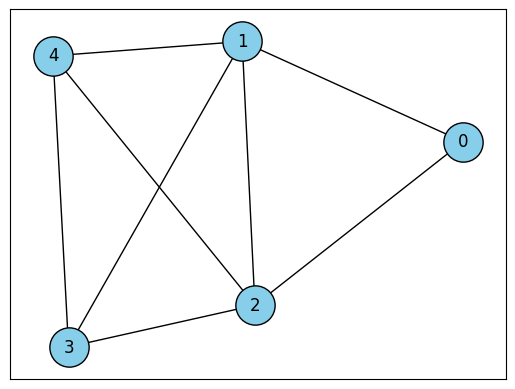

In [2]:
import networkx as nx

# Define nodes and edges
nodes = [0, 1, 2, 3, 4]
edges = [(0,1), (0,2), (1,2), (1,3), (2,3), (1,4), (2,4), (3,4)]

# Construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Layout to draw the graph
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos)

Let's divide the nodes of $\mathbf{G}(\mathbf{N},\mathbf{E})$ in $\mathbf{U}$ and $\mathbf{U}'$.
$\mathbf{U}$ contains nodes $0$ and $2$. $\mathbf{U}'$ contains nodes $1$ and $3$.

We call this a *partition*. Below, a dictionary of key-value pairs is defined to represent this partition. 
All nodes are keys and values are either $0$ or $1$. 
For node $n \in \mathbf{N}$ value $0$ means $n \in \mathbf{U}$ and value $1$ means $n \in \mathbf{U}'$.

In [3]:
partition = {0:0, 1:1, 2:0, 3:1, 4:0}

Below Python function `show_graph` is defined to draw a graph showing the nodes in $\mathbf{U}$ in blue and the nodes in $\mathbf{U}'$ in green. Edges $u u' \in \delta(\mathbf{U})$ are shown in red.

In [4]:
import networkx as nx

def show_graph_partition(nodes, edges, partition):
    """
    Show graph partition

    Parameters:
    nodes        : list of nodes 
    edges        : list of edges
    partition    : graph partition
    """

    # Construct the graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Layout to draw the graph
    pos = nx.spring_layout(G, seed=42)

    # Colors for the nodes
    colors = ['skyblue' if partition[node] == 0 else 'lightgreen' for node in G.nodes()]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, edgecolors='black')
    nx.draw_networkx_labels(G, pos)

    # Divide the edges between `cut` edges and `same` edges
    cut_edges = [(u, v) for u, v in G.edges() if partition[u] != partition[v]]
    same_edges = [(u, v) for u, v in G.edges() if partition[u] == partition[v]]

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=same_edges, width=1.5, style='solid', edge_color='black')
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2.5, style='dashed', edge_color='red')

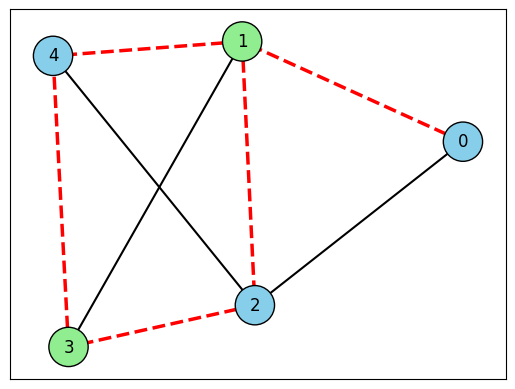

In [5]:
show_graph_partition(nodes, edges, partition)

For a given partition $\mathbf{U}$ and $\mathbf{U}'$, the number of edges in the cut, $|\delta(\mathbf{U})|$, can
be computed by function `cut_size` defined below.

In [6]:
def cut_size(edges, partition):
    return sum(1 for u, v in edges if partition[u] != partition[v])

For the example given above, the cut size can be determined:

In [7]:
print(f"Partition: {partition}")
print(f"Cut size for this partition: {cut_size(edges, partition)}")

Partition: {0: 0, 1: 1, 2: 0, 3: 1, 4: 0}
Cut size for this partition: 5


## Quantum Annealing
Quantum annealing starts with superposition of all possible states with equal weights. The system evolves following 
the time-dependent Schr&ouml;dinger equation.

Consider the *problem* Hamiltonian $H_P$ and assume that $H_P$ is a classical many-body Ising Hamiltonian described in terms 
of the $z$ components for the Pauli operator ${\sigma_j^z}$.
We also introduce a *driver* Hamiltonian $H_D$ which is not commutative with $H_P$ and has the trivial ground state.
A straightforward choice for $H_D$ is the transverse field: $H_D = -\sum_j \sigma_j^x$, so that $H_D$ does not commute with $H_P$.
The total Hamiltonian of quantum annealing is given as

$H(t) = A(t) H_D + B(t) H_P$,

where $A(t)$ and $B(t)$ represent the scheduling function satisfying $A(t_i) \gg B(t_i)$ at initial time $t_i$ and
$A(t_f) \ll B(t_f)$ at final time $t_f$ so that $H(t)$ interpolates between $H_D$ at $t=t_i$ and $H_P$ at $t=t_f$.
The initial state at $t=t_i$ is set at the ground state of $H_D \approx H(t_i)/A(t_i)$. If the change in $H(t)$ with
$t$ is 'sufficiently' small, the spin state evolves adiabatically, i.e., stays in the ground state of instantaneous
Hamiltonian, and arrives at the ground state of $H_P$ at $t=t_f$, which represents the solution we hope to find.

## Simulation of QA
Below class *QuantumAnnealingCircuit* is defined which is based in these principles and inherits from class *Circuit* of QuantumSim.
In this implementation $A(t)$ and $B(t)$ are defined by

$A(t) = 1 - \frac{t}{T}$

$B(t) = \frac{t}{T}$,

where $T = t_f - t_i$. These definitions satisfy $A(t_i) \gg B(t_i)$ at initial time $t_i$ and
$A(t_f) \ll B(t_f)$ at final time $t_f$. For $t_i = 0$ it holds $A(t_i) = 1$, and thus $H_D \approx H(t_i)/A(t_i)$.

The system evolves according to the time-dependent Schr&ouml;dinger equation:

$i \hbar \frac{d}{dt} |\psi(t)\rangle = H(t) |\psi(t)\rangle$.

The system starts in the ground state of $H_D$ at $t=t_i$. According the the *adiabatic theorem*, the system will stay in the ground state
of the instantaneous Hamiltonian $H(t)$ if the evolution is slow enough. At $t=t_f$, the state $|\psi(t)\rangle$ should be close to 
the ground state of $H_P$, i.e., the optimal solution.

To simulate quantum annealing, we simplify the equation somewhat by setting Planck's constant $\hbar = 1$.
Thus, the equation becomes:

$i \frac{d}{dt} |\psi(t)\rangle = H(t) |\psi(t)\rangle$.

The Hamiltonian $H(t)$ changes with time. Under the assumption that $H(t)$ remains constant during a short 
period of time $\Delta t$, the evolution of the quantum state over $\Delta t$ can be described by

$|\psi(t + \Delta t)\rangle = U(t + \Delta t,t) |\psi(t)\rangle$, 

where $U(t + \Delta t,t)$ is the time-evolution operator for time $t$, which can be approximated by

$U(t + \Delta t,t) \approx \exp(-i H(t) \Delta t)$,

which corresponds to the line

`U = expm(-1j * H_t * dt)`

in method `execute()` of class *QuantumAnnealingCircuit*.


In [8]:
from scipy.linalg import expm

'''
Class representing a quantum annealing circuit of N qubits.
Inherits from Circuit.
'''
class QuantumAnnealingCircuit(Circuit):
    def __init__(self, N:int, T:float, steps:int, interactions:list[tuple]):
        """
        Constructor

        Parameters:
        N            : number of qubits
        T            : total time
        steps        : number of time steps
        interactions : interactions between qubits 
        """
        # Initialize state vector
        super().__init__(N)

        # Settings for time evolution
        self.T = T
        self.steps = steps

        # Driver Hamiltonian
        self.H_D = np.zeros([2**N, 2**N], dtype=complex)
        for q in range(N):
            pauli_x = CircuitUnitaryOperation.get_combined_operation_for_pauli_x(q, N)
            self.H_D = self.H_D - pauli_x

        # Problem Hamiltonian
        self.H_P = np.zeros([2**N, 2**N], dtype=complex)
        for i,j in interactions:
            cnot = CircuitUnitaryOperation.get_combined_operation_for_cnot(i, j, N)
            pauli_z = CircuitUnitaryOperation.get_combined_operation_for_pauli_z(j, N)
            self.H_P = self.H_P + np.dot(cnot, np.dot(pauli_z, cnot))

    def execute(self, print_state=False):
        """
        Override method execute
        """
        # Initialize state in uniform superposition |++...++>
        self.state_vector.state_vector = [1/np.sqrt(2**self.N)] * 2**self.N
        self.quantum_states = [self.state_vector.get_quantum_state()]

        # Time evolution
        dt = self.T / self.steps
        t = 0
        for i in range(self.steps):
            t = t + dt
            A_t = 1 - t/self.T
            B_t = t/self.T
            H_t = A_t * self.H_D + B_t * self.H_P
            U = expm(-1j * H_t * dt)
            self.state_vector.apply_unitary_operation(U)
            self.quantum_states.append(self.state_vector.get_quantum_state())

Create an instance of *QuantumAnnealingCircuit* to solve the Max-Cut problem for the example graph.
The number of qubits is equal to the number of nodes in the graph and determines the driver Hamiltonian $H_D$.
The edges of the graph describe the interactions between the qubits and determine the problem Hamiltonian $H_P$.

In [9]:
N = G.number_of_nodes()
T = 10
steps = 100
circuit = QuantumAnnealingCircuit(N=N, T=T, steps=steps, interactions=edges)

Execute and measure circuit 1000 times.

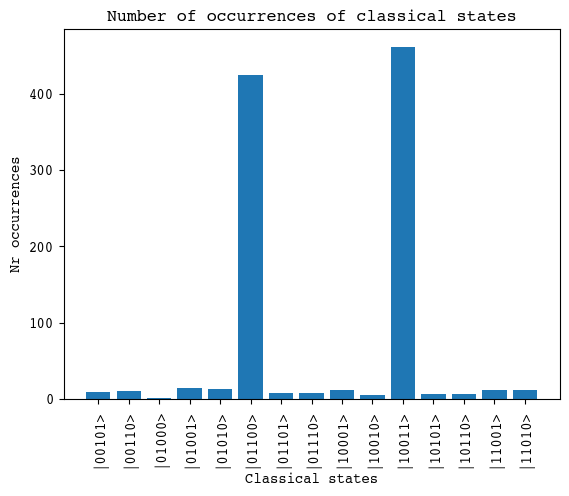

In [10]:
nr_measurements = 1000
result = QuantumUtil.measure_circuit(circuit, nr_measurements=nr_measurements)
QuantumUtil.histogram_of_classical_states(result)

Below, a Python function is defined to compute partition corresponding to most occurring measurement.

In [11]:
def compute_partition(nodes:list, result:list) -> dict:
    """
    Compute partition from the most occurring measurement

    Parameters:
    nodes  : list of nodes
    result : list of strings containing measurements

    Returns:
    Partition corresponding to most occurring result
    """

    # Count occurrences of each string in result
    counter = Counter(result)

    # Get the most occurring string from result
    most_common_string = counter.most_common(1)[0][0]

    # Determine partition corresponding to the most occurring string
    bit_string = most_common_string[1:-1]
    partition = {node: 0 if bit_string[node] == '0' else 1 for node in nodes}

    # Return partition corresponding to the most occurrring string in result
    return partition

We use this function to determine the partition corresponding to the most occurring measurement 
and then we compute its cut size and show the partition.

Partition {0: 1, 1: 0, 2: 0, 3: 1, 4: 1} has cut size 6


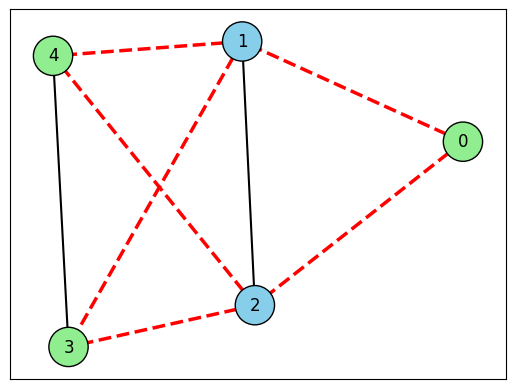

In [12]:
partition = compute_partition(nodes, result)
partition_cut_size = cut_size(edges, partition)
print(f"Partition {partition} has cut size {partition_cut_size}")

show_graph_partition(nodes, edges, partition)

Below we show the time evolution of the probabilities during quantum annealing.

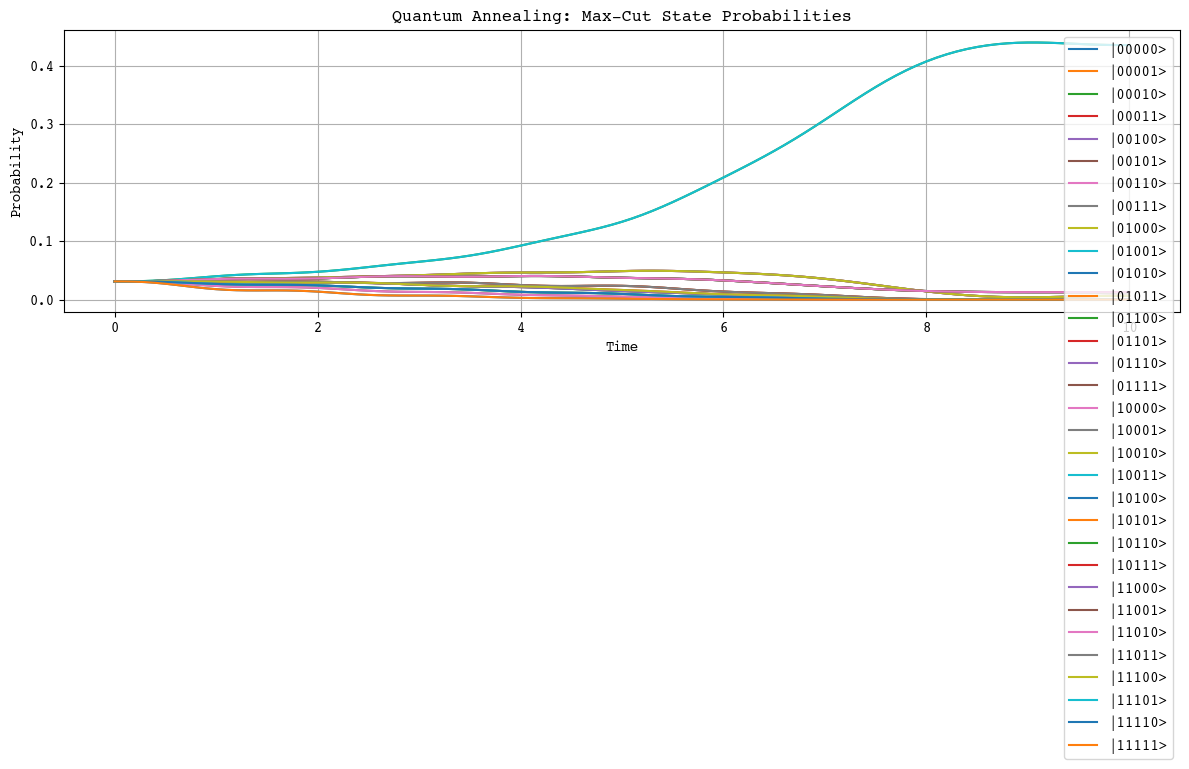

In [13]:
nr_states = len(circuit.quantum_states)
all_probabilities = np.zeros([2**N,nr_states])
i = 0
for state in circuit.quantum_states:
    all_probabilities[:,i] = np.square(np.abs(state)).flatten()
    i = i + 1

times = np.linspace(0, T, steps+1)
basis_states = [f"{Dirac.state_as_string(i,N)}" for i in range(2**N)]

plt.figure(figsize=(12, 6))
for i in range(2**N):
     plt.plot(times, all_probabilities[i,:], label=basis_states[i])
plt.title("Quantum Annealing: Max-Cut State Probabilities")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion
We have shown that it is relatively straightforward to simulate QA using QuantumSim.

You can further experiment with this notebook by choosing a different graph, i.e., different choices for `nodes` and `edges` or by
choosing other values for time `T` and the number of steps `steps`. For example, increasing `T` also increases the probability
that the system will end at one of the optimal solutions. However, this is also dependent on `steps` determining
the time step $\Delta t$.